# Graph Coloring Problem

An example in which the Graph Coloring problem is solved using a Branch & Price algorithm.

$$
 \begin{align}
     \text{min} \quad & \sum_{c \in C} y_{c} \\
     \text{s.t} \quad & \sum_{c \in C} x_{i, c} = 1 & \forall \; i \in N \\
     & x_{i, c} + x_{j, c} \leq y_{c} & \forall \; i, j \in E, c \in C \\
     & y_{C_{k-1}} \leq y_{C_{k}} & \forall \; k \in (2, ..., |C|) \\
     & x_{i, c} \in \{0, 1\} & \forall \; i \in N, c \in C \\
     & y_{c} \in \{0, 1\} & \forall \; c \in C
 \end{align}
 $$

In [1]:
from bnbprob import gcol
from bnbpy import BranchAndBound, configure_logfile

## Heuristics

We can solve the problem using heuristics, which can be useful in B&B for pruning the search space. By default, the DSatur heuristic is implemented as warmstart.

In [2]:
# Instance has a list of tuples (edges) in which node indexes start at 0
instance = gcol.load_instance("./../data/gcol/gcol32.txt")

In [3]:
configure_logfile("gcol.log", mode="w")

In [4]:
# Heuristic solution
dsatur = gcol.DSatur()
graph = gcol.ColorGraph(instance["edges"])
dsatur.solve(graph, save_history=True)
print(f"DSatur solution: {len(graph.colors)}")

DSatur solution: 9


If the argument `save_history` is set to `True`, you can also create animations of the solution process.

```python
gcol.draw_colored_gif(
    "gcol-gif.gif",
    graph.nodes,
    dsatur.history,
    seed=12, use_labels=False, plot_margins=False
)
```

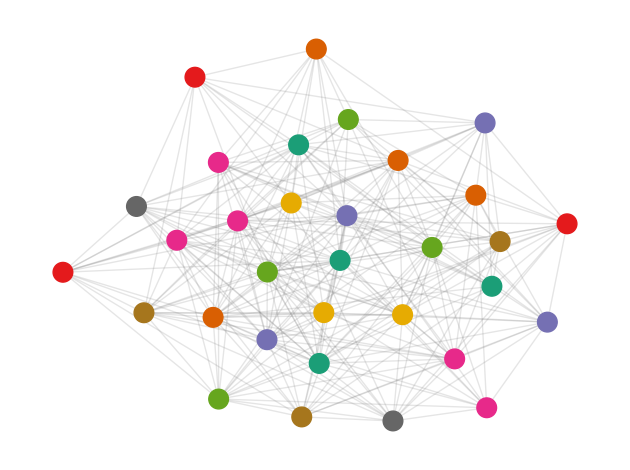

In [5]:
gcol.draw_gc_from_nodes(
    graph.nodes, seed=12, use_labels=False, plot_margins=False
)

## Branch & Price

### Moderate instances

In moderate instances, I suggest to adopt as pricing problem a combination of heuristics and exact solution (via `scipy`) to the Maximum Weighted Independent Set Problem (MWISP). A targeted multistart (for the reduced cost) can be a good heuristic alternative.

In [6]:
# Instance has a list of tuples (edges) in which node indexes start at 0
instance = gcol.load_instance("./../data/gcol/gcol_50_7.txt")

In [7]:
bnb = BranchAndBound()
price_tol = 0.1
pricing = gcol.ColorHybrPricing(
    instance["edges"],
    heur=gcol.TargetMultiStart(
        12, price_tol + 1, 20, 200
    ),
    price_tol=price_tol,
    mip_rel_gap=1e-2
)
problem = gcol.ColGenColor(
    instance['edges'],
    pricing=pricing,
    max_iter_price=1000,
)
sol = bnb.solve(problem, maxiter=1000)
print(sol)

Status: OPTIMAL | Cost: 14.0 | LB: 14.0


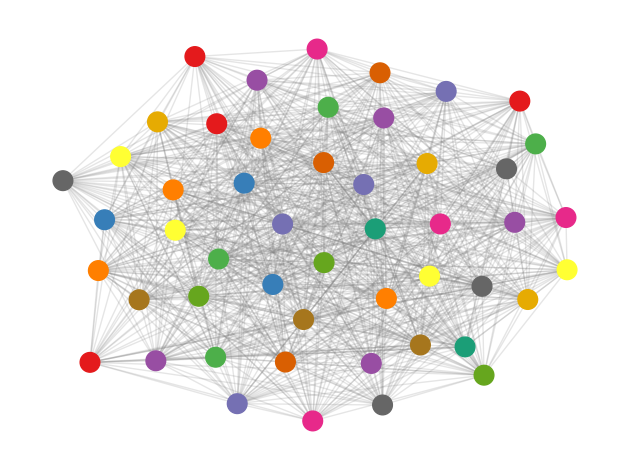

In [8]:
graph = gcol.ColorGraph(instance["edges"])
gcol.graph_from_solution(graph, sol.problem.results)
gcol.draw_gc_from_nodes(
    graph.nodes, seed=12, use_labels=False, plot_margins=False
)

### Larger Instances

Larger instances might offer a challenge in a sense that computing the exact solutions to the pricing problem might become too expensive. An alternative is to use only heuristics for producing new columns.

In [9]:
# Instance has a list of tuples (edges) in which node indexes start at 0
instance = gcol.load_instance("./../data/gcol/gcol100.txt")

#### Callbacks

We can also include a callback to try to create integer solutions from the Independent Set (master) problem.

In [10]:
from scipy.optimize import linprog

from bnbpy import Node


class CallbackBnB(BranchAndBound):

    def post_eval_callback(self, node: Node):
        # If not root node of at every 100 levels of depth, continue
        if node.parent is not None and node.level % 100 == 0:
            return
        # Solve the master problem with integrality predefined
        sol = linprog(
            node.problem.milp.c,
            A_ub=node.problem.milp.A_ub,
            b_ub=node.problem.milp.b_ub,
            bounds=(0, 1),
            integrality=1,
            options={"mip_rel_gap": 0.01, "time_limit": 120}
        )
        # If the solution is successful, we create a new node and assign
        # scipy results to it
        print(sol)
        if sol.success and int(round(sol.fun, 1)) < self.ub:
            problem: gcol.ColGenColor = node.problem.copy()
            problem.results.set_results(sol)
            new_node = Node(problem)
            solution = new_node.solution
            solution.set_lb(int(round(sol.fun, 4)))
            new_node.set_solution(solution)
            # If we confirm the problem is feasible, we set a new solution
            if new_node.check_feasible():
                self.set_solution(new_node)
                print("New solution found:")
                print(new_node.solution)

In [11]:
bnb = CallbackBnB(rtol=1e-2)
price_tol = 1e-1
pricing = gcol.ColorHeurPricing(
    instance["edges"],
    heur=gcol.TargetMultiStart(
        42, 1.0 + price_tol, 50, 100
    ),
    price_tol=price_tol
)
problem = gcol.ColGenColor(
    instance['edges'],
    pricing=pricing,
    max_iter_price=1000,
)
sol = bnb.solve(problem, maxiter=1000, timelimit=600)
print(sol)

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 17.00000000000002
              x: [ 1.000e+00  1.000e+00 ... -0.000e+00  0.000e+00]
            nit: 273856
          lower:  residual: [ 1.000e+00  1.000e+00 ... -0.000e+00
                              0.000e+00]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [ 0.000e+00  0.000e+00 ...  1.000e+00
                              1.000e+00]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              1.288e-14]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
 mip_node_count: 3618
 mip_dual_bound: 17.000000

In [13]:
graph = gcol.ColorGraph(instance["edges"])
gcol.graph_from_solution(graph, bnb.incumbent.problem.results)

And maybe plot it... Which might be confusing.

```python
gcol.draw_gc_from_nodes(
    graph.nodes, seed=12, use_labels=False, plot_margins=False
)
```

## Solvers

You can always try to benchmark versus usual solvers. See here a quick example using Gurobi.

```python
import gurobipy as grb

model = grb.Model()

C = list(range(17))
N = instance["nodes"]
E = instance["edges"]

x = model.addVars(N, C, vtype="B")
y = model.addVars(C, vtype="B")

model.addConstrs((x.sum(i, "*") == 1 for i in N))
model.addConstrs((x[i, c] + x[j, c] <= y[c] for (i, j) in E for c in C))

model.setObjective(y.sum("*"))

model.optimize()
```